In [1]:
# 20180420 update
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## def(td,ff,px): # where td is dataframe, ff & px are column names of failflag and probdefault
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

In [3]:
## make ctlst (cutlist) of 73 points spaced for good charts:
ctlst2 = list(np.arange(0,2,.1)) + list(np.arange(2,5,.5)) + list(np.arange(5,15,1)) + list(np.arange(15,90,5))
ctlst2 = ctlst2 + list(np.arange(90,97,1)) + list(np.arange(97,99,.5)) + list(np.arange(99,100,.1)) + [100]
#ctlst = [np.round(x,1) for x in ctlst]
ctlst = [np.round(float(x)/100,3) for x in ctlst2]
ctlst[40:50]

[0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

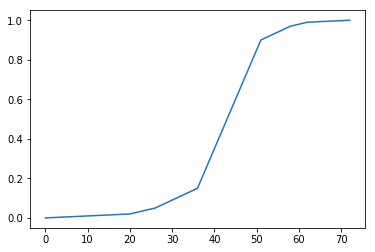

In [4]:
plt.plot(np.arange(len(ctlst)),ctlst)

In [5]:
## function for roc points (ctlst: 73 cuts) (1.1 sec to solve):
def roc(td,ff,px,ct):
  pn = td[td[ff]==0][[px,ff]]
  py = td[td[ff]==1][[px,ff]]

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list

  xm = pd.DataFrame(columns=['cut','fail', 'surv', 'sens', 'spec', 'FPR'],dtype='float')

  for i in np.arange(len(ct)):
    x1 = ct[i]
    x2 = sum((py[px] > x1)*1)
    x3 = sum((pn[px] > x1)*1)
    x4 = float(x2)/float(ly)
    x5 = float(ln - x3)/float(ln)
    x6 = 1 - x5
    xm=xm.append({'cut':x1,'fail':x2,'surv':x3,'sens':x4,'spec':x5,'FPR':x6},ignore_index=True)

  return xm

In [6]:
### read in all bank data with ratios to run ROC analyses:
dff = pd.read_csv("allbanks_f2468_roe0mm2_20091231.csv",index_col=0)
dff['AsOf'] = pd.to_datetime(dff['AsOf'])
dff['FailDate'] = pd.to_datetime(dff['FailDate'])
dff.head()

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   
2      37 2002-06-30  BANK OF HANCOCK COUNTY    GA  69304.0  0.364757   
3      37 2002-09-30  BANK OF HANCOCK COUNTY    GA  71970.0  0.495989   
4      37 2002-12-31  BANK OF HANCOCK COUNTY    GA  74327.0  0.610962   

    qnTotLn      rNIM     rPPNR      rROA  ...  f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385  ...   0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604  ...   0   0   0        1.0   
2  0.206747  4.599485  1.927457  1.294383  ...   0   0   0        1.0   
3  0.325492  4.492631  1.833764  1.235163  ...   0   0   0        1.0   
4  0.268236  4.436347  1.816232  1.214158  ...   0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  2.058829e-08  2.717914e-08  3.115884e-07  1.946419e-08  3.834514e-07   
1  2.347768e-08  3.114855e-08  3.492824e-07  2.272195e-08  4.348963e-07   
2  2.964976e-08  3.903344e-08  4.268433e-07  2.958268e-08  5.377538e-07   
3  5.010822e-08  6.527011e-08  6.729683e-07  5.381529e-08  8.755665e-07   
4  1.823329e-08  2.512681e-08  2.832182e-07  1.746288e-08  3.551453e-07   

       f6_5  
0  0.000002  
1  0.000002  
2  0.000003  
3  0.000004  
4  0.000002  

[5 rows x 33 columns]

In [7]:
prm0 = pd.read_csv("f246_params_roe0mm2_2009.csv",index_col=0)
#prm225 = pd.read_csv("f246_params_alt225mm_2009.csv",index_col=0)

In [8]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0    0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   
1    0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   
2    3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184   
3    2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948   
4    4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   
5    4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1   lnTotAst  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  eBrok_Dep  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  eBrok_Dep  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4       rROA  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5       rROE  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [9]:
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [10]:
fcol = [x for x in list(dff.columns) if x[0:1]=='f']
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [11]:
targ = pd.to_datetime('2009-12-31')
thresh = 0 ## no minimum size threshold (not needed)
alt = '' ## or alt = ''
dfh = dff[(dff['AsOf']<=targ)&(dff['eTotAst']>(thresh*1000))]\
      [['IDRSSD','AsOf','Name','FailDate']+xcol+fcol]
#dfr09 = sm.add_constant(dfr09)
len(dfh), len(dff) # 259210, 489464

(259210, 489464)

In [12]:
dfh[xcol].max()

rcTotLn      3.543633e+03
qnTotLn      1.000000e+02
rNIM         4.160000e+04
rPPNR        5.272914e+02
rROA         3.423426e+02
rROE         5.877828e+02
rEff         5.480120e+07
eLn_Dep      9.934150e+02
aFF_TA       1.534201e+02
eBrok_Dep    1.000000e+02
eT1rb        1.999829e+02
eTotrb       2.268312e+02
eALLL_Ln     1.000000e+02
lnTotAst     2.129349e+01
dtype: float64

In [13]:
dfh[xcol].min()

rcTotLn     -5.000000e-01
qnTotLn      0.000000e+00
rNIM        -1.360000e+04
rPPNR       -6.429146e+01
rROA        -7.697304e+01
rROE        -1.998472e+02
rEff        -3.359000e+08
eLn_Dep      0.000000e+00
aFF_TA      -2.722560e+02
eBrok_Dep    0.000000e+00
eT1rb        0.000000e+00
eTotrb       0.000000e+00
eALLL_Ln     0.000000e+00
lnTotAst     6.486161e+00
dtype: float64

In [14]:
## screening criteria:
dfh.dropna(how='any',inplace=True,subset=dfh.columns[8:])  # delete any ratio columns with NaN values (note columns[8:])
dfh= dfh[dfh['eLn_Dep']<=1000]
dfh= dfh[dfh['eBrok_Dep']<=100]
dfh= dfh[dfh['eALLL_Ln']<=100]
dfh= dfh[dfh['rROE']>=-200]
dfh= dfh[dfh['lnTotAst']>2]
dfh= dfh[dfh['eT1rb']<=200]
len(dfh) # 259210

259210

In [15]:
## set fflags to zero if FailDate after targ2 date (12/31/2010); that is, for f4
## increment date by interval:
targ2 = targ+timedelta(days=365)
dfh.ix[dfh.FailDate>targ2,['f2','f4','f6','f8']] = [0,0,0,0]
targ2

Timestamp('2010-12-31 00:00:00')

In [16]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2011-03-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head(8)

IDRSSD       AsOf                   Name   FailDate  f2  f4  f6  f8
5764    16337 2009-09-30           WAKULLA BANK 2010-10-01   0   0   1   1
5765    16337 2009-12-31           WAKULLA BANK 2010-10-01   0   1   1   1
15410   41647 2009-09-30   FIRST BANKING CENTER 2010-11-19   0   0   1   1
15411   41647 2009-12-31   FIRST BANKING CENTER 2010-11-19   0   1   1   1
20565   54357 2009-09-30  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
20566   54357 2009-12-31  FIRST STATE BANK, THE 2011-01-28   0   0   0   0
44940  117841 2009-09-30   EVERGREEN STATE BANK 2011-01-28   0   0   0   0
44941  117841 2009-12-31   EVERGREEN STATE BANK 2011-01-28   0   0   0   0

In [17]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2012-01-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head()

IDRSSD       AsOf                 Name   FailDate  f2  f4  f6  f8
5764   16337 2009-09-30         WAKULLA BANK 2010-10-01   0   0   1   1
5765   16337 2009-12-31         WAKULLA BANK 2010-10-01   0   1   1   1
7410   20370 2009-09-30  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
7411   20370 2009-12-31  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
8585   23241 2009-09-30      INTEGRA BANK NA 2011-07-29   0   0   0   0

In [18]:
dff.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5'],
      dtype='object')

In [19]:
dfh.columns

Index(['IDRSSD', 'AsOf', 'Name', 'FailDate', 'rcTotLn', 'qnTotLn', 'rNIM',
       'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA', 'eBrok_Dep',
       'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'f2', 'f4', 'f6', 'f8',
       'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5'],
      dtype='object')

In [20]:
### generate forecasts for all 4-var models:
dv4 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4 = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])

for idx, row in prm0.iterrows():
  fv = row['fx']
  x = idx
  eqnc = fv + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
  res = sm.Logit(yc, Xc).fit()
  dv4 = dv4.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                    'v3':row['v3'],'r3': row['r3'], 'v4':row['v4'],'r4': res.prsquared},ignore_index=True)
  cm = pd.DataFrame(res.params).T
  cm.columns = ['Int','c1','c2','c3','c4']
  cm['idx'] = idx
  cm['v4'] = row['v4']
  cv4 = cv4.append(cm.ix[0])
  pred_tot = res.predict(Xc)
  dfh[fv+'_'+str(x)+'rr'] = pred_tot
  p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
  dff[fv+'_'+str(x)+'rr'] = p_tot

cv4 = cv4.reset_index(drop=True)
dv4 = dv4.reset_index(drop=True)
dv4 = dv4.merge(cv4, how='inner', on=['idx','v4'])


Optimization terminated successfully.
         Current function value: 0.004107
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004167
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010750
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010819
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019313
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.019328
         Iterations 12


In [21]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192  eBrok_Dep   
1   1  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   lnTotAst   
2   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184  eBrok_Dep   
3   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   5  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [22]:
prm0

idx  fx     v1        r1       v2        r2         v3        r3  \
0    0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   
1    0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   
2    3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184   
3    2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948   
4    4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   
5    4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1   lnTotAst  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  eBrok_Dep  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  eBrok_Dep  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4       rROA  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5       rROE  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [23]:
dv4.to_csv("modelrerun_f246_params_roe0mm2_2009.csv")

In [24]:
fcolrr = [x for x in list(dff.columns) if x[0:1]=='f']
fcolrr

['f2',
 'f4',
 'f6',
 'f8',
 'f2_0',
 'f2_1',
 'f4_2',
 'f4_3',
 'f6_4',
 'f6_5',
 'f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr']

In [25]:
dffsum=dff[['AsOf']+fcolrr].groupby('AsOf').sum()
dffsum.ix['2009':'2010']

f2   f4   f6   f8       f2_0       f2_1        f4_2        f4_3  \
AsOf                                                                          
2009-03-31  55  129  204  255  41.047195  39.644066   94.179977   95.231093   
2009-06-30  59  137  196  239  50.569192  51.485298  112.633981  110.172213   
2009-09-30  54  124  175  219  50.506030  51.802099  116.975583  112.566970   
2009-12-31  66  125  168  211  75.399783  76.943245  154.942748  150.892574   
2010-03-31  55  106  149  181  72.780963  76.729630  144.476386  130.712871   
2010-06-30  43   86  129  153  60.102415  65.763784  121.242272  104.653194   
2010-09-30  36   79  110  130  54.319558  59.986522  109.626120   91.212582   
2010-12-31  34   77  101  119  53.605208  58.166840  108.968236   97.566538   

                  f6_4        f6_5     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                   
2009-03-31  140.889838  138.625685  41.047195  39.644066   94.179977   
2009-06-30  159.774041  161.191152  50.569192  51.485298  112.633981   
2009-09-30  166.186486  170.061167  50.506030  51.802099  116.975583   
2009-12-31  202.940601  207.580806  75.399783  76.943245  154.942748   
2010-03-31  177.726321  191.406805  72.780963  76.729630  144.476386   
2010-06-30  147.428768  164.221781  60.102415  65.763784  121.242272   
2010-09-30  129.836853  149.606498  54.319558  59.986522  109.626120   
2010-12-31  134.130202  147.649403  53.605208  58.166840  108.968236   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   95.231093  140.889838  138.625685  
2009-06-30  110.172213  159.774041  161.191152  
2009-09-30  112.566970  166.186486  170.061167  
2009-12-31  150.892574  202.940601  207.580806  
2010-03-31  130.712871  177.726321  191.406805  
2010-06-30  104.653194  147.428768  164.221781  
2010-09-30   91.212582  129.836853  149.606498  
2010-12-31   97.566538  134.130202  147.649403

In [26]:
## single variable models for all fx:
dvv = pd.DataFrame(columns=['fx','v1', 'r1'])
cvv = pd.DataFrame(columns=['fx','v1','Int','c1'])

vr=prm0[['v1','v2','v3','v4']].values
vrlst = list(set(e for r in vr for e in r))  ## list of unique variables among coefficients
vrlst = vrlst + ['eLn_Dep','aFF_TA']

for x in vrlst:
  for y in ['f2','f4','f6']:
    eqnc = y + " ~ " + x  # regression eqn
    pvar = ["Intercept", x]  # var for predictions
    yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
    res = sm.Logit(yc, Xc).fit()
    dvv = dvv.append({'fx':y,'v1':x,'r1':res.prsquared},ignore_index=True)
    cm = pd.DataFrame(res.params).T
    cm.columns = ['Int','c1']
    cm['fx'] = y
    cm['v1'] = x
    cvv = cvv.append(cm)
    pred_tot = res.predict(Xc)
    dfh[y+'_'+x] = pred_tot
    p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
    dff[y+'_'+x] = p_tot

cvv = cvv.reset_index(drop=True)
dvv = dvv.reset_index(drop=True)
dvv = dvv.merge(cvv, how='inner', on=['fx','v1'])

Optimization terminated successfully.
         Current function value: 0.005078
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.014221
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.025339
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009202
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018572
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.028259
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.010041
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.022062
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033123
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.0

In [27]:
dvv

fx         v1            r1        Int        c1
0   f2      eT1rb  5.221243e-01   2.875025 -0.973274
1   f4      eT1rb  3.976050e-01   3.686162 -0.908604
2   f6      eT1rb  2.906983e-01   2.973008 -0.756279
3   f2    qnTotLn  1.341141e-01  -6.971926  0.169443
4   f4    qnTotLn  2.133018e-01  -6.355191  0.275215
5   f6    qnTotLn  2.089553e-01  -5.882838  0.300752
6   f2  eBrok_Dep  5.514164e-02  -6.895088  0.041498
7   f4  eBrok_Dep  6.549667e-02  -5.973650  0.042619
8   f6  eBrok_Dep  7.281008e-02  -5.488328  0.043709
9   f2   lnTotAst  2.776448e-02 -11.112936  0.371887
10  f4   lnTotAst  2.937546e-02 -10.070537  0.363334
11  f6   lnTotAst  3.106602e-02  -9.560640  0.362184
12  f2       rROA  1.433615e-01  -6.615136 -0.286966
13  f4       rROA  1.533202e-01  -5.667674 -0.350139
14  f6       rROA  1.306842e-01  -5.124670 -0.357018
15  f2       rROE  4.917893e-01  -7.333741 -0.056760
16  f4       rROE  4.001283e-01  -6.054406 -0.060519
17  f6       rROE  3.039817e-01  -5.317120 -0.058299
18  f2    eLn_Dep  1.975284e-03  -6.860932  0.003604
19  f4    eLn_Dep  4.018038e-03  -5.987523  0.004277
20  f6    eLn_Dep  6.638744e-03  -5.546010  0.004869
21  f2     aFF_TA  2.756565e-03  -6.672363  0.019747
22  f4     aFF_TA  8.814205e-04  -5.691086  0.011326
23  f6     aFF_TA  2.374905e-07  -5.142546  0.000193

In [28]:
dvv.to_csv("SingleVar_params_roe0mm2_2009.csv")

In [29]:
dff.to_csv("allbanks_f2468_roe0mm2_20091231_singles.csv")
dfh.to_csv("modelbanks_f2468_roe0mm2_2009_singles.csv")

In [30]:
fcol = [x for x in list(dff.columns) if x[0]=='f']
fcol[10:26]

['f2_0rr',
 'f2_1rr',
 'f4_2rr',
 'f4_3rr',
 'f6_4rr',
 'f6_5rr',
 'f2_eT1rb',
 'f4_eT1rb',
 'f6_eT1rb',
 'f2_qnTotLn',
 'f4_qnTotLn',
 'f6_qnTotLn',
 'f2_eBrok_Dep',
 'f4_eBrok_Dep',
 'f6_eBrok_Dep',
 'f2_lnTotAst']

In [31]:
fnbr = dff[['AsOf']+fcol[0:5]+fcol[10:16]].groupby('AsOf').sum()
fnbr['2009':'2011']

f2   f4   f6   f8       f2_0     f2_0rr     f2_1rr      f4_2rr  \
AsOf                                                                         
2009-03-31  55  129  204  255  41.047195  41.047195  39.644066   94.179977   
2009-06-30  59  137  196  239  50.569192  50.569192  51.485298  112.633981   
2009-09-30  54  124  175  219  50.506030  50.506030  51.802099  116.975583   
2009-12-31  66  125  168  211  75.399783  75.399783  76.943245  154.942748   
2010-03-31  55  106  149  181  72.780963  72.780963  76.729630  144.476386   
2010-06-30  43   86  129  153  60.102415  60.102415  65.763784  121.242272   
2010-09-30  36   79  110  130  54.319558  54.319558  59.986522  109.626120   
2010-12-31  34   77  101  119  53.605208  53.605208  58.166840  108.968236   
2011-03-31  33   64   86   97  47.815405  47.815405  52.769084   96.560558   
2011-06-30  27   50   67   78  38.723081  38.723081  43.479908   81.919759   
2011-09-30  19   39   50   62  36.355316  36.355316  41.159837   74.937138   
2011-12-31  18   36   48   56  32.045756  32.045756  35.953175   66.237951   

                f4_3rr      f6_4rr      f6_5rr  
AsOf                                            
2009-03-31   95.231093  140.889838  138.625685  
2009-06-30  110.172213  159.774041  161.191152  
2009-09-30  112.566970  166.186486  170.061167  
2009-12-31  150.892574  202.940601  207.580806  
2010-03-31  130.712871  177.726321  191.406805  
2010-06-30  104.653194  147.428768  164.221781  
2010-09-30   91.212582  129.836853  149.606498  
2010-12-31   97.566538  134.130202  147.649403  
2011-03-31   82.062921  114.656766  130.621317  
2011-06-30   66.630848   96.027720  113.369096  
2011-09-30   60.269803   86.003483  102.692985  
2011-12-31   57.932945   81.256579   91.960507

In [32]:
dffg = dff[dff['AsOf']>'2009-01-01'][['AsOf']+fcol]

In [33]:
len(dffg) # 259479

259479

In [34]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
500257 2018-12-31   0   0   0   0  2.326798e-09  4.265311e-09  6.038859e-08   
500261 2018-12-31   0   0   0   0  3.286985e-27  3.508229e-26  3.094466e-23   

                f4_3          f6_4  ...   f6_rROA   f2_rROE   f4_rROE  \
500257  2.410549e-08  7.359160e-07  ...  0.172436  0.002403  0.009350   
500261  1.723974e-28  5.039630e-23  ...  0.073667  0.001209  0.004512   

         f6_rROE  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  f2_aFF_TA  f4_aFF_TA  \
500257  0.018402    0.001328    0.003318    0.005354   0.003417   0.005944   
500261  0.009163    0.001177    0.002875    0.004550   0.004053   0.006554   

        f6_aFF_TA  
500257   0.005865  
500261   0.005875  

[2 rows x 41 columns]

In [35]:
dffg[['f4','f6']].groupby('f4').count() # 258155, 1324

f6
f4        
0   258155
1     1324

In [36]:
dff[['f4','f6']].groupby('f4').count() # 487733, 1731

f6
f4        
0   487733
1     1731

In [37]:
%time xc = roc(dffg, 'f4', 'f4_2', ctlst) # 0.505sec

Wall time: 2.01 s


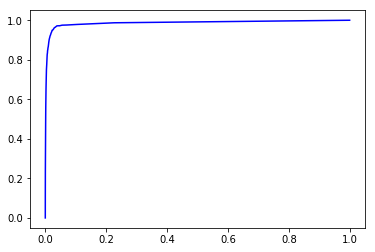

In [38]:
plt.plot(xc['FPR'],xc['sens'],c='b')

In [39]:
def auc(td,ff,px):
  pn = td[td[ff]==0][[px,ff]]
  pn.reset_index(drop=True, inplace=True)
  py = td[td[ff]==1][[px,ff]]
  py.reset_index(drop=True, inplace=True)

  ln = len(pn)  # number of elements in non-failed list
  ly = len(py)   # number of elements in failed list
  cs = 0  # count successes

  for j in np.arange(ly):
    x = ( pn[px] < py.ix[j][px] )*1
    cs = cs + sum(x)

  r = float(cs) / float(ln * ly)  # area under curve
  return r  ## .982024 in excel

%time x = auc(dffg, 'f4', 'f4_2rr') # 6.65sec

Wall time: 31.3 s


In [40]:
x # .98697

0.9869706751857139

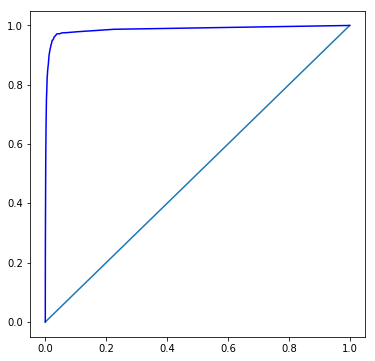

In [41]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,1],[0,1])
plt.plot(xc['FPR'],xc['sens'],c='b')
plt.show()

In [42]:
f4lst=[x for x in list(dffg.columns) if x[0:2]=='f4']  ## all f4 columns
fxlst= [x for x in f4lst if x not in ['f4','f4_2','f4_3','f4_aFF_TA']]  ## no f4; only vars used in models plus 2 dummy vars
f4lst, fxlst

(['f4',
  'f4_2',
  'f4_3',
  'f4_2rr',
  'f4_3rr',
  'f4_eT1rb',
  'f4_qnTotLn',
  'f4_eBrok_Dep',
  'f4_lnTotAst',
  'f4_rROA',
  'f4_rROE',
  'f4_eLn_Dep',
  'f4_aFF_TA'],
 ['f4_2rr',
  'f4_3rr',
  'f4_eT1rb',
  'f4_qnTotLn',
  'f4_eBrok_Dep',
  'f4_lnTotAst',
  'f4_rROA',
  'f4_rROE',
  'f4_eLn_Dep'])

In [43]:
f4auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in fxlst:
  y = auc(dffg, 'f4', x)
  f4auc=f4auc.append({'modvar':x,'auc':y, 'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f4_2rr
f4_3rr
f4_eT1rb
f4_qnTotLn
f4_eBrok_Dep
f4_lnTotAst
f4_rROA
f4_rROE
f4_eLn_Dep


In [44]:
f4auc['aucs'] = f4auc.apply(lambda x: str(np.round(x['auc']*100,1)),axis=1)
f4auc

modvar       auc  aucs
0        f4_2rr  0.986971  98.7
1        f4_3rr  0.986648  98.7
2      f4_eT1rb  0.978526  97.9
3    f4_qnTotLn  0.955572  95.6
4  f4_eBrok_Dep  0.603566  60.4
5   f4_lnTotAst  0.537846  53.8
6       f4_rROA  0.969812  97.0
7       f4_rROE  0.976804  97.7
8    f4_eLn_Dep  0.542800  54.3

In [45]:
f4auc.to_csv("f4auc_roe0mm2_20091231.csv")

In [46]:
f6lst0=[x for x in list(dffg.columns) if x[0:2]=='f6']  ## all f4 columns
f6lst= [x for x in f6lst0 if x not in ['f6','f6_4','f6_5','f6_aFF_TA']] 
f6lst

['f6_4rr',
 'f6_5rr',
 'f6_eT1rb',
 'f6_qnTotLn',
 'f6_eBrok_Dep',
 'f6_lnTotAst',
 'f6_rROA',
 'f6_rROE',
 'f6_eLn_Dep']

In [47]:
f6auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f6lst:
  y = auc(dffg, 'f6', x)
  f6auc=f6auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f6_4rr
f6_5rr
f6_eT1rb
f6_qnTotLn
f6_eBrok_Dep
f6_lnTotAst
f6_rROA
f6_rROE
f6_eLn_Dep


In [48]:
f2lst0=[x for x in list(dffg.columns) if x[0:2]=='f2']  ## all f4 columns
f2lst= [x for x in f2lst0 if x not in ['f2','f2_0','f2_1','f2_aFF_TA']] 
f2lst

['f2_0rr',
 'f2_1rr',
 'f2_eT1rb',
 'f2_qnTotLn',
 'f2_eBrok_Dep',
 'f2_lnTotAst',
 'f2_rROA',
 'f2_rROE',
 'f2_eLn_Dep']

In [49]:
f2auc = pd.DataFrame(columns=['modvar','auc','aucs'])

for x in f2lst:
  y = auc(dffg, 'f2', x)
  f2auc=f2auc.append({'modvar':x,'auc':y,'aucs': str(np.round(y*100,1))},ignore_index=True)
  print(x)

f2_0rr
f2_1rr
f2_eT1rb
f2_qnTotLn
f2_eBrok_Dep
f2_lnTotAst
f2_rROA
f2_rROE
f2_eLn_Dep


In [50]:
f2auc

modvar       auc  aucs
0        f2_0rr  0.989720  99.0
1        f2_1rr  0.987695  98.8
2      f2_eT1rb  0.985226  98.5
3    f2_qnTotLn  0.961212  96.1
4  f2_eBrok_Dep  0.577496  57.7
5   f2_lnTotAst  0.533544  53.4
6       f2_rROA  0.973520  97.4
7       f2_rROE  0.981345  98.1
8    f2_eLn_Dep  0.515012  51.5

In [51]:
f2auc.to_csv("f2auc_roe0mm2_20091231.csv")

In [52]:
f6auc.to_csv("f6auc_roe0mm2_20091231.csv")

In [53]:
f6auc

modvar       auc  aucs
0        f6_4rr  0.984347  98.4
1        f6_5rr  0.984593  98.5
2      f6_eT1rb  0.970372  97.0
3    f6_qnTotLn  0.949304  94.9
4  f6_eBrok_Dep  0.615311  61.5
5   f6_lnTotAst  0.538664  53.9
6       f6_rROA  0.963559  96.4
7       f6_rROE  0.969095  96.9
8    f6_eLn_Dep  0.560094  56.0

In [54]:
%time y = roc(dffg, 'f4', 'f4_2rr',ctlst)

Wall time: 1.91 s


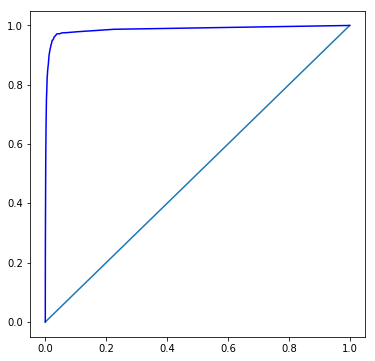

In [55]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot([0,1],[0,1])
plt.plot(y['FPR'],y['sens'],c='b')
plt.show()

In [56]:
#f4roc:
for i in np.arange(len(fxlst)):
#for i in np.arange(2):
  v = fxlst[i]
  y = roc(dffg, 'f4', v, ctlst)
  if i == 0:
    f4roc = y[['cut','sens','FPR']]
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f4roc = f4roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f4roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f4roc.to_csv("f4rocpts_roe0mm2_2009.csv")
f4roc.head()    

cut  f4_2rr_sens  f4_2rr_FPR  f4_3rr_sens  f4_3rr_FPR  f4_eT1rb_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000       1.000000   
1  0.001     0.987160    0.226689     0.984894    0.193732       0.971299   
2  0.002     0.978852    0.105654     0.978097    0.099839       0.965257   
3  0.003     0.975831    0.070341     0.974320    0.068137       0.960725   
4  0.004     0.975076    0.055207     0.972810    0.054258       0.956193   

   f4_eT1rb_FPR  f4_qnTotLn_sens  f4_qnTotLn_FPR  f4_eBrok_Dep_sens  \
0      1.000000         1.000000        1.000000           1.000000   
1      0.191013         1.000000        1.000000           1.000000   
2      0.118774         0.985650        0.610114           1.000000   
3      0.084550         0.966767        0.258996           0.515106   
4      0.064287         0.943353        0.158722           0.323263   

   f4_eBrok_Dep_FPR  f4_lnTotAst_sens  f4_lnTotAst_FPR  f4_rROA_sens  \
0          1.000000          1.000000         1.000000      1.000000   
1          1.000000          1.000000         0.998640      1.000000   
2          1.000000          0.929003         0.913699      0.996224   
3          0.224051          0.679758         0.613271      0.979607   
4          0.096357          0.388218         0.344467      0.960725   

   f4_rROA_FPR  f4_rROE_sens  f4_rROE_FPR  f4_eLn_Dep_sens  f4_eLn_Dep_FPR  
0     1.000000      1.000000     1.000000         1.000000        1.000000  
1     0.990231      0.994713     0.870454         1.000000        1.000000  
2     0.877911      0.975831     0.207158         1.000000        1.000000  
3     0.251911      0.966767     0.084879         0.991692        0.926319  
4     0.084418      0.959970     0.060367         0.021148        0.036203

In [57]:
######### CAUTION ############################################
# shortcut to skip earlier processing and get to charts below
##############################################################

## read auc files:
#f2auc= pd.read_csv("f2auc_roe0mm2_20091231.csv",index_col=0)
#f4auc= pd.read_csv("f4auc_roe0mm2_20091231.csv",index_col=0)
#f6auc= pd.read_csv("f6auc_roe0mm2_20091231.csv",index_col=0)
#f2auc['aucs'] = f2auc['aucs'].astype(str)
#f4auc['aucs'] = f4auc['aucs'].astype(str)
#f6auc['aucs'] = f6auc['aucs'].astype(str)

## read roc files:
#f2roc= pd.read_csv("f2rocpts_roe0mm2_2009.csv",index_col=0)
#f4roc= pd.read_csv("f4rocpts_roe0mm2_2009.csv",index_col=0)
#f6roc= pd.read_csv("f6rocpts_roe0mm2_2009.csv",index_col=0)

In [58]:
f2auc.dtypes

modvar     object
auc       float64
aucs       object
dtype: object

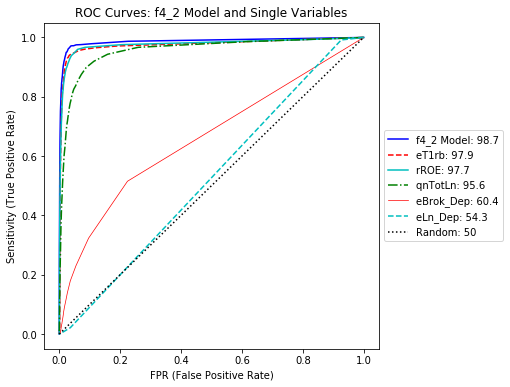

In [59]:
## Code to resize chart frame !!!!!!
#f4auc['aucs'] = f4auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f4roc['f4_2rr_FPR'],f4roc['f4_2rr_sens'],c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR'],f4roc['f4_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR'],f4roc['f4_rROE_sens'],c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR'],f4roc['f4_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR'],f4roc['f4_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
plt.plot(f4roc['f4_eLn_Dep_FPR'],f4roc['f4_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f4_2 Model and Single Variables')
plt.savefig('ROC_f4_roe0mm2_2009.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
#f6roc:
for i in np.arange(len(f6lst)):
#for i in np.arange(2):
  v = f6lst[i]
  y = roc(dffg, 'f6', v, ctlst)
  if i == 0:
    f6roc = y[['cut','sens','FPR']]
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f6roc = f6roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f6roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f6roc.to_csv("f6rocpts_roe0mm2_2009.csv")
f6roc.head()    

cut  f6_4rr_sens  f6_4rr_FPR  f6_5rr_sens  f6_5rr_FPR  f6_eT1rb_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000       1.000000   
1  0.001     0.991914    0.397801     0.992453    0.458490       0.972507   
2  0.002     0.984906    0.245905     0.988140    0.278643       0.964960   
3  0.003     0.983288    0.166013     0.982749    0.179611       0.957412   
4  0.004     0.978437    0.121573     0.980054    0.127430       0.953100   

   f6_eT1rb_FPR  f6_qnTotLn_sens  f6_qnTotLn_FPR  f6_eBrok_Dep_sens  \
0      1.000000         1.000000        1.000000                1.0   
1      0.336731         1.000000        1.000000                1.0   
2      0.240273         1.000000        1.000000                1.0   
3      0.184362         0.986523        0.725763                1.0   
4      0.146958         0.974663        0.393977                1.0   

   f6_eBrok_Dep_FPR  f6_lnTotAst_sens  f6_lnTotAst_FPR  f6_rROA_sens  \
0               1.0          1.000000         1.000000      1.000000   
1               1.0          1.000000         0.999984      1.000000   
2               1.0          0.999461         0.995505      1.000000   
3               1.0          0.961725         0.946589      0.996765   
4               1.0          0.848518         0.797911      0.985984   

   f6_rROA_FPR  f6_rROE_sens  f6_rROE_FPR  f6_eLn_Dep_sens  f6_eLn_Dep_FPR  
0     1.000000      1.000000     1.000000              1.0        1.000000  
1     0.993510      0.998383     0.990125              1.0        1.000000  
2     0.987482      0.993531     0.901108              1.0        1.000000  
3     0.940095      0.980054     0.586087              1.0        1.000000  
4     0.696441      0.969272     0.245843              1.0        0.992245

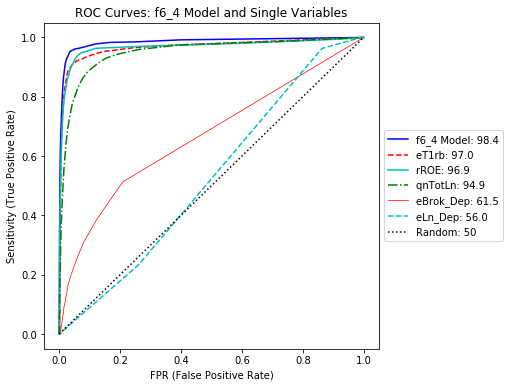

In [61]:
## Code to resize chart frame !!!!!!
#f6auc['aucs'] = f6auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f6roc['f6_4rr_FPR'],f6roc['f6_4rr_sens'],c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR'],f6roc['f6_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR'],f6roc['f6_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR'],f6roc['f6_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
plt.plot(f6roc['f6_eLn_Dep_FPR'],f6roc['f6_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f6_4 Model and Single Variables')
plt.savefig('ROC_f6_roe0mm2_2009.png', dpi=300, bbox_inches='tight')
plt.show()

In [62]:
#f2roc:
for i in np.arange(len(f2lst)):
#for i in np.arange(2):
  v = f2lst[i]
  y = roc(dffg, 'f2', v, ctlst)
  if i == 0:
    f2roc = y[['cut','sens','FPR']]
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)
  else:
    f2roc = f2roc.merge(y[['cut','sens','FPR']],how='left',on='cut')
    f2roc.rename(columns={'FPR':v+'_FPR','sens':v+'_sens'},inplace=True)

f2roc.to_csv("f2rocpts_roe0mm2_2009.csv")
f2roc.head()    

cut  f2_0rr_sens  f2_0rr_FPR  f2_1rr_sens  f2_1rr_FPR  f2_eT1rb_sens  \
0  0.000     1.000000    1.000000     1.000000    1.000000       1.000000   
1  0.001     0.978328    0.053057     0.976780    0.063083       0.973684   
2  0.002     0.976780    0.034292     0.973684    0.037240       0.970588   
3  0.003     0.976780    0.027728     0.972136    0.029007       0.964396   
4  0.004     0.969040    0.024058     0.969040    0.024958       0.956656   

   f2_eT1rb_FPR  f2_qnTotLn_sens  f2_qnTotLn_FPR  f2_eBrok_Dep_sens  \
0      1.000000         1.000000        1.000000           1.000000   
1      0.062144         0.987616        0.667276           1.000000   
2      0.034285         0.919505        0.091812           0.179567   
3      0.025905         0.842105        0.042599           0.103715   
4      0.022609         0.732198        0.027091           0.065015   

   f2_eBrok_Dep_FPR  f2_lnTotAst_sens  f2_lnTotAst_FPR  f2_rROA_sens  \
0          1.000000          1.000000         1.000000      1.000000   
1          1.000000          0.795666         0.758165      0.987616   
2          0.052505          0.218266         0.190864      0.930341   
3          0.022381          0.077399         0.066568      0.770898   
4          0.013839          0.037152         0.035764      0.631579   

   f2_rROA_FPR  f2_rROE_sens  f2_rROE_FPR  f2_eLn_Dep_sens  f2_eLn_Dep_FPR  
0     1.000000      1.000000     1.000000              1.0        1.000000  
1     0.646482      0.973684     0.068473              1.0        1.000000  
2     0.045072      0.964396     0.034107              0.0        0.001140  
3     0.020334      0.953560     0.025399              0.0        0.000444  
4     0.012004      0.944272     0.020828              0.0        0.000251

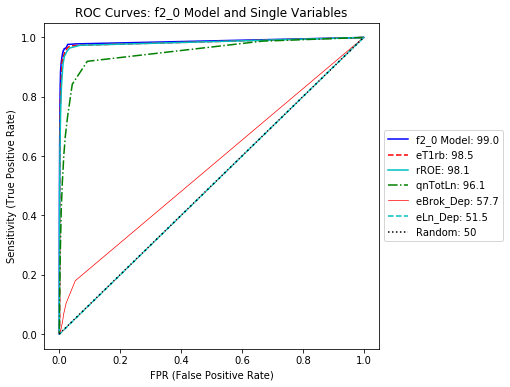

In [63]:
## Code to resize chart frame !!!!!!
#f2auc['aucs'] = f2auc.apply(lambda x:str(np.round(x['auc']*100,1)),axis=1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1, plSize[1]*1.5) )  ## double width, single height
plt.plot(f2roc['f2_0rr_FPR'],f2roc['f2_0rr_sens'],c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR'],f2roc['f2_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR'],f2roc['f2_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR'],f2roc['f2_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
plt.plot(f2roc['f2_eLn_Dep_FPR'],f2roc['f2_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.title('ROC Curves: f2_0 Model and Single Variables')
plt.savefig('ROC_f2_roe0mm2_2009.png', dpi=300, bbox_inches='tight')
plt.show()

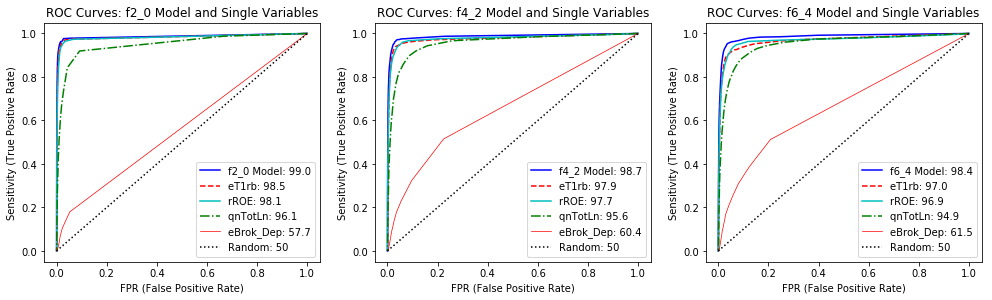

In [64]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.8, plSize[1]*1.1) )  ## double width, single height

plt.subplot(1, 3, 1)
dauc= dict(zip(f2auc['modvar'],f2auc['aucs']))

params = plt.gcf()
plt.plot(f2roc['f2_0rr_FPR'],f2roc['f2_0rr_sens'],c='b',lw=1.5,label=('f2_0 Model: '+dauc['f2_0rr']))
#plt.plot(f2roc['f2_1_FPR'],f2roc['f2_1_sens'],c='b',ls='--',label='f2_1: '+dauc['f2_1'])
plt.plot(f2roc['f2_eT1rb_FPR'],f2roc['f2_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f2_eT1rb'])
plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_qnTotLn_FPR'],f2roc['f2_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f2_qnTotLn'])
#plt.plot(f2roc['f2_rROE_FPR'],f2roc['f2_rROE_sens'],c='c',label='rROE: '+dauc['f2_rROE'])
plt.plot(f2roc['f2_eBrok_Dep_FPR'],f2roc['f2_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f2_eBrok_Dep'])
#plt.plot(f2roc['f2_eLn_Dep_FPR'],f2roc['f2_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f2_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4, fontsize=10)
plt.title('ROC Curves: f2_0 Model and Single Variables')

plt.subplot(1, 3, 2)
dauc= dict(zip(f4auc['modvar'],f4auc['aucs']))

params = plt.gcf()
plt.plot(f4roc['f4_2rr_FPR'],f4roc['f4_2rr_sens'],c='b',lw=1.5,label='f4_2 Model: '+dauc['f4_2rr'])
#plt.plot(f4roc['f4_3rr_FPR'],f4roc['f4_3rr_sens'],c='b',ls='--',label='f4 Model2: '+dauc['f4_3rr'])
plt.plot(f4roc['f4_eT1rb_FPR'],f4roc['f4_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f4_eT1rb'])
#plt.plot(f4roc['f4_rROA_FPR'],f4roc['f4_rROA_sens'],c='c',ls='--',label='rROA: '+dauc['f4_rROA'])
plt.plot(f4roc['f4_rROE_FPR'],f4roc['f4_rROE_sens'],c='c',label='rROE: '+dauc['f4_rROE'])
plt.plot(f4roc['f4_qnTotLn_FPR'],f4roc['f4_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f4_qnTotLn'])
plt.plot(f4roc['f4_eBrok_Dep_FPR'],f4roc['f4_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f4_eBrok_Dep'])
#plt.plot(f4roc['f4_eLn_Dep_FPR'],f4roc['f4_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f4_eLn_Dep'])
#plt.plot(f4roc['f4_aFF_TA_FPR'],f4roc['f4_aFF_TA_sens'],c='g',ls='--',label='aFF_TA: '+dauc['f4_aFF_TA'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4,fontsize=10)
plt.title('ROC Curves: f4_2 Model and Single Variables')

plt.subplot(1, 3, 3)
dauc= dict(zip(f6auc['modvar'],f6auc['aucs']))

params = plt.gcf()
plt.plot(f6roc['f6_4rr_FPR'],f6roc['f6_4rr_sens'],c='b',lw=1.5,label=('f6_4 Model: '+dauc['f6_4rr']))
#plt.plot(f6roc['f6_1_FPR'],f6roc['f6_1_sens'],c='b',ls='--',label='f6_1: '+dauc['f6_1'])
plt.plot(f6roc['f6_eT1rb_FPR'],f6roc['f6_eT1rb_sens'],c='r',ls='--',label='eT1rb: '+dauc['f6_eT1rb'])
plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',ls='-',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_qnTotLn_FPR'],f6roc['f6_qnTotLn_sens'],c='g',ls='-.',label='qnTotLn: '+dauc['f6_qnTotLn'])
#plt.plot(f6roc['f6_rROE_FPR'],f6roc['f6_rROE_sens'],c='c',label='rROE: '+dauc['f6_rROE'])
plt.plot(f6roc['f6_eBrok_Dep_FPR'],f6roc['f6_eBrok_Dep_sens'],c='r',lw=.7,label='eBrok_Dep: '+dauc['f6_eBrok_Dep'])
#plt.plot(f6roc['f6_eLn_Dep_FPR'],f6roc['f6_eLn_Dep_sens'],c='c',ls='--',label='eLn_Dep: '+dauc['f6_eLn_Dep'])
plt.plot([0,1],[0,1],ls=':',c='k',label='Random: 50')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('FPR (False Positive Rate)')
plt.legend(loc=4, fontsize=10)
plt.title('ROC Curves: f6_4 Model and Single Variables')

plt.savefig('ROC_f246_roe0mm2_2009.png', dpi=400, bbox_inches='tight')
plt.show()

In [65]:
## identify optimal cut-off point

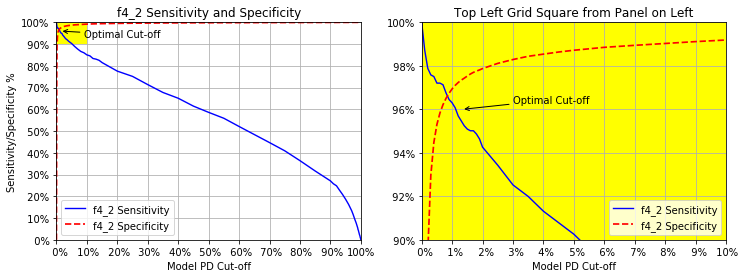

In [66]:
from matplotlib.patches import Rectangle

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.09, .93),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity')
plt.grid(True)


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid(True)
plt.savefig('SensSpecOptCut_f4_2_roe0mm2_2009.png', dpi=400, bbox_inches='tight')
plt.show()

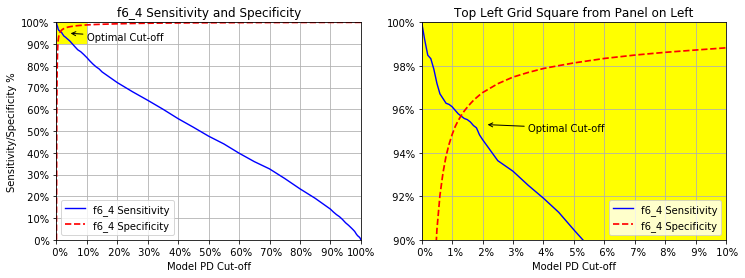

In [67]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.04,.95), xytext=(.1, .92),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity')
plt.grid(True)


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.021,.953), xytext=(.035, .95),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid(True)
plt.savefig('SensSpecOptCut_f6_4_roe0mm2_2009.png', dpi=400, bbox_inches='tight')
plt.show()

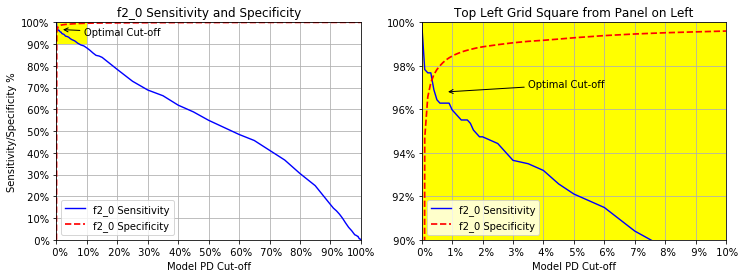

In [68]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.annotate('Optimal Cut-off', xy=(.015,.967), xytext=(.09, .94),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity')
plt.grid(True)


plt.subplot(1, 2, 2)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.008,.968), xytext=(.035, .97),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square from Panel on Left')
plt.grid(True)

plt.savefig('SensSpecOptCut_f2_0_roe0mm2_2009.png', dpi=400, bbox_inches='tight')
plt.show()


In [69]:
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 3, 1)
plt.plot(f2roc['cut'],f2roc['f2_0rr_sens'],'b-',lw=1.4,label='f2_0 Sensitivity')
plt.plot(f2roc['cut'],(1-f2roc['f2_0rr_FPR']),'r--',lw=1.7,label='f2_0 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.ylabel('Sensitivity/Specificity %')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.008,.968), xytext=(.035, .97),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f2_0 Sensitivity and Specificity (partial)')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f4_2 Sensitivity and Specificity (partial)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(f6roc['cut'],f6roc['f6_4rr_sens'],'b-',lw=1.4,label='f6_4 Sensitivity')
plt.plot(f6roc['cut'],(1-f6roc['f6_4rr_FPR']),'r--',lw=1.7,label='f6_4 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
#plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=4)

plt.annotate('Optimal Cut-off', xy=(.021,.953), xytext=(.035, .95),
            arrowprops=dict(arrowstyle = '->'))

plt.title('f6_4 Sensitivity and Specificity (partial)')
plt.grid(True)

plt.savefig('SensSpecOptCut_f246partial_roe0mm2_2009.png', dpi=400, bbox_inches='tight')
plt.show()

In [70]:
from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow",lw=0))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.7,label='f4_2 Specificity')
plt.ylim([0,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(0,1.01,.1)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,1])
xtix = np.arange(.0,1.01,.1)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=3)
plt.title('f4_2 Sensitivity and Specificity')
plt.grid(True)
plt.show()

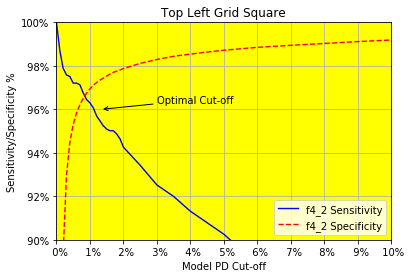

In [71]:
from matplotlib.patches import Rectangle
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0, .9), .1, .1, facecolor="yellow"))
plt.plot(f4roc['cut'],f4roc['f4_2rr_sens'],'b-',lw=1.4,label='f4_2 Sensitivity')
plt.plot(f4roc['cut'],(1-f4roc['f4_2rr_FPR']),'r--',lw=1.4,label='f4_2 Specificity')
plt.ylim([.9,1.])
# convert decimals to percentages with % symbols:
ytix = np.arange(.9,1.01,.02)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Sensitivity/Specificity %')
plt.xlim([0,.1])
xtix = np.arange(.0,.101,.01)  # list of ticks on y-axis
xlbl = ['{:3.0f}%'.format(x*100) for x in xtix] # mult by 100 and add % symbol
plt.xticks(xtix, xlbl)
plt.xlabel('Model PD Cut-off')
plt.legend(loc=0)

plt.annotate('Optimal Cut-off', xy=(.0133,.96), xytext=(.03, .963),
            arrowprops=dict(arrowstyle = '->'))

plt.title('Top Left Grid Square')
plt.grid(True)
plt.show()

In [72]:
dffg.tail(2)

AsOf  f2  f4  f6  f8          f2_0          f2_1          f4_2  \
500257 2018-12-31   0   0   0   0  2.326798e-09  4.265311e-09  6.038859e-08   
500261 2018-12-31   0   0   0   0  3.286985e-27  3.508229e-26  3.094466e-23   

                f4_3          f6_4  ...   f6_rROA   f2_rROE   f4_rROE  \
500257  2.410549e-08  7.359160e-07  ...  0.172436  0.002403  0.009350   
500261  1.723974e-28  5.039630e-23  ...  0.073667  0.001209  0.004512   

         f6_rROE  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  f2_aFF_TA  f4_aFF_TA  \
500257  0.018402    0.001328    0.003318    0.005354   0.003417   0.005944   
500261  0.009163    0.001177    0.002875    0.004550   0.004053   0.006554   

        f6_aFF_TA  
500257   0.005865  
500261   0.005875  

[2 rows x 41 columns]

In [73]:
#### section to process problem bank list 12/31/2010:
pbk = pd.read_csv('ProbBank20101231.csv',skiprows=3,encoding='latin1')
pbk['Date'] = pd.to_datetime(pbk['Date'])
pbk['Prompt Corrective Action Date'] = pd.to_datetime(pbk['Prompt Corrective Action Date'])

In [74]:
pbk.head()

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   
2        1149                 116962    SM    FRB   
3        3564                 319321     N    OCC   
4       57157                  83618    NM   FDIC   

                                 Name             City State       Date  \
0                   1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1   1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   
2                  1st Financial Bank    Overland Park    KS 2009-06-22   
3  1st National Bank of South Florida        Homestead    FL 2010-06-29   
4                    1st Regents Bank          Andover    MN 2010-03-24   

  Enforcement Action Type       Reason Prompt Corrective Action  \
0           Consent Order      Capital                      NaN   
1   Supervisory Agreement      General                      NaN   
2       Written Agreement      General                      NaN   
3           Consent Order  CRE lending                      NaN   
4           Consent Order       C&D RE                      NaN   

  Prompt Corrective Action Date Ticker Symbol  
0                           NaT           CBC  
1                           NaT           NaN  
2                           NaT           NaN  
3                           NaT           NaN  
4                           NaT           NaN

In [75]:
pbk['prob'] = 1
pbk.head()

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   
2        1149                 116962    SM    FRB   
3        3564                 319321     N    OCC   
4       57157                  83618    NM   FDIC   

                                 Name             City State       Date  \
0                   1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1   1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   
2                  1st Financial Bank    Overland Park    KS 2009-06-22   
3  1st National Bank of South Florida        Homestead    FL 2010-06-29   
4                    1st Regents Bank          Andover    MN 2010-03-24   

  Enforcement Action Type       Reason Prompt Corrective Action  \
0           Consent Order      Capital                      NaN   
1   Supervisory Agreement      General                      NaN   
2       Written Agreement      General                      NaN   
3           Consent Order  CRE lending                      NaN   
4           Consent Order       C&D RE                      NaN   

  Prompt Corrective Action Date Ticker Symbol  prob  
0                           NaT           CBC     1  
1                           NaT           NaN     1  
2                           NaT           NaN     1  
3                           NaT           NaN     1  
4                           NaT           NaN     1

In [76]:
rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult201812.csv", index_col=0)  # this version has top100 banks assigned to merger parents
rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])

In [77]:
pbk = pbk.merge(rk[['xCert','IDRSSD']],how='left',left_on='FDIC Cert#',right_on='xCert')
pbk.head(2)

FDIC Cert#  2010q3 Assets $(000s) Class Agency  \
0       58358                  43893    NM   FDIC   
1       58773                  57903    SA    OTS   

                                Name             City State       Date  \
0                  1st Commerce Bank  North Las Vegas    NV 2010-07-13   
1  1st Commonwealth Bank of Virginia        Arlington    VA 2010-08-20   

  Enforcement Action Type   Reason Prompt Corrective Action  \
0           Consent Order  Capital                      NaN   
1   Supervisory Agreement  General                      NaN   

  Prompt Corrective Action Date Ticker Symbol  prob    xCert     IDRSSD  
0                           NaT           CBC     1  58358.0  3465383.0  
1                           NaT           NaN     1  58773.0  3688678.0

In [78]:
dff10 = dff[dff['AsOf']=='2010-12-31']
dff10 = dff10.merge(pbk[['IDRSSD','prob']],how='left',on = 'IDRSSD')
dff10.head(2)

IDRSSD       AsOf                              Name State  eTotAst  \
0      37 2010-12-31            BANK OF HANCOCK COUNTY    GA  83515.0   
1     242 2010-12-31  FIRST COMMUNITY BANK XENIA-FLORA    IL  32756.0   

    rcTotLn   qnTotLn      rNIM     rPPNR      rROA  ...   f2_rROE   f4_rROE  \
0  0.632531  3.814983  3.922807  1.097109  0.743125  ...  0.000533  0.001886   
1  0.055148  0.271248  4.003830  1.490713  1.555913  ...  0.000329  0.001129   

    f6_rROE  f2_eLn_Dep  f4_eLn_Dep  f6_eLn_Dep  f2_aFF_TA  f4_aFF_TA  \
0  0.003966    0.001340    0.003353    0.005419   0.001363   0.003513   
1  0.002421    0.001493    0.003811    0.006267   0.001300   0.003420   

   f6_aFF_TA prob  
0   0.005813  NaN  
1   0.005810  NaN  

[2 rows x 64 columns]

In [79]:
dff10[['prob','f4','f4_2']].groupby('prob').sum()

f4       f4_2
prob               
1.0   68  84.851108

In [80]:
dff10['prob']=dff10['prob'].fillna(0)

In [81]:
dff10['decile'] = pd.qcut(dff10['f4_2'], 10, labels=False)
dff10[['f4_2','decile']].groupby('decile').mean()

f4_2
decile          
0       0.000002
1       0.000028
2       0.000100
3       0.000221
4       0.000395
5       0.000625
6       0.000944
7       0.001426
8       0.002711
9       0.151475

In [82]:
dff10['decile'] = pd.qcut(dff10['f4_2'], 10, labels=False)
dff10[['f4_2','decile']].groupby('decile').sum()

f4_2
decile            
0         0.001057
1         0.019306
2         0.068955
3         0.152771
4         0.272455
5         0.430839
6         0.651597
7         0.982351
8         1.870874
9       104.518030

In [83]:
dff10p = dff10[dff10['prob']==1]
dff10p['decile'] = pd.qcut(dff10p['f4_2'], 10, labels=False)
dff10p[['f4_2','decile']].groupby('decile').mean()

f4_2
decile          
0       0.000144
1       0.000589
2       0.001101
3       0.001875
4       0.003125
5       0.006779
6       0.016696
7       0.046847
8       0.203196
9       0.745327

In [84]:
dff10p[['f4_2','decile']].groupby('decile').sum()

f4_2
decile           
0        0.011986
1        0.048309
2        0.090291
3        0.153724
4        0.256241
5        0.555886
6        1.369066
7        3.841446
8       16.662033
9       61.862127

In [85]:
dff10p0 = dff10[dff10['prob']==0]
dff10p0['decile'] = pd.qcut(dff10p0['f4_2'], 10, labels=False)
dff10p0[['f4_2','decile']].groupby('decile').mean()

f4_2
decile          
0       0.000001
1       0.000020
2       0.000077
3       0.000174
4       0.000312
5       0.000507
6       0.000751
7       0.001107
8       0.001727
9       0.034995

In [86]:
dff10p0[['f4_2','decile']].groupby('decile').sum()

f4_2
decile           
0        0.000650
1        0.012341
2        0.046770
3        0.105371
4        0.189834
5        0.307589
6        0.455948
7        0.673129
8        1.048423
9       21.277071

In [87]:
#############################################################################
## NOTE:  try Worst 3% & 4% & 5% of f4 scores... 
#############################################################################

In [88]:
dq95 = dff[['AsOf','f2_0','f2_1','f4_2','f4_3','f6_4','f6_5']].groupby('AsOf').quantile(.95)
dq95.rename(columns={'f2_0':'w5_2_0','f2_1':'w5_2_1','f4_2':'w5_4_2','f4_3':'w5_4_3','f6_4':'w5_6_4',\
                     'f6_5':'w5_6_5'},inplace=True)
dq96 = dff[['AsOf','f2_0','f2_1','f4_2','f4_3','f6_4','f6_5']].groupby('AsOf').quantile(.96)
dq96.rename(columns={'f2_0':'w4_2_0','f2_1':'w4_2_1','f4_2':'w4_4_2','f4_3':'w4_4_3','f6_4':'w4_6_4',\
                     'f6_5':'w4_6_5'},inplace=True)
dq97 = dff[['AsOf','f2_0','f2_1','f4_2','f4_3','f6_4','f6_5']].groupby('AsOf').quantile(.97)
dq97.rename(columns={'f2_0':'w3_2_0','f2_1':'w3_2_1','f4_2':'w3_4_2','f4_3':'w3_4_3','f6_4':'w3_6_4',\
                      'f6_5':'w3_6_5'},inplace=True)
#dqt = dq97.merge(dq96,how='left',left_index=True,right_index=True)
#dqt = dqt.merge(dq95,how='left',left_index=True,right_index=True)
dqt = pd.concat([dq97,dq96,dq95], axis=1)
dqt.ix['2010':'2011']

w3_2_0    w3_2_1    w3_4_2    w3_4_3    w3_6_4    w3_6_5  \
AsOf                                                                     
2010-03-31  0.028310  0.029925  0.132729  0.117779  0.208587  0.231806   
2010-06-30  0.018115  0.018088  0.090601  0.080710  0.156276  0.176103   
2010-09-30  0.015232  0.015876  0.078906  0.068451  0.149063  0.150918   
2010-12-31  0.016695  0.018341  0.074246  0.078165  0.139970  0.138157   
2011-03-31  0.013575  0.014654  0.062567  0.060446  0.112634  0.125880   
2011-06-30  0.010691  0.011682  0.051002  0.049295  0.098357  0.107484   
2011-09-30  0.009145  0.009707  0.044885  0.041718  0.084323  0.092198   
2011-12-31  0.007943  0.008897  0.036790  0.041976  0.084189  0.076715   

              w4_2_0    w4_2_1    w4_4_2    w4_4_3    w4_6_4    w4_6_5  \
AsOf                                                                     
2010-03-31  0.011673  0.012206  0.057267  0.055760  0.114436  0.115706   
2010-06-30  0.008319  0.009197  0.043003  0.041078  0.085501  0.089043   
2010-09-30  0.007931  0.008680  0.038332  0.035816  0.081713  0.085291   
2010-12-31  0.008418  0.008609  0.037867  0.041632  0.083561  0.084701   
2011-03-31  0.006043  0.007339  0.030406  0.030234  0.062022  0.061631   
2011-06-30  0.005265  0.005837  0.025849  0.025111  0.054633  0.055438   
2011-09-30  0.004040  0.004385  0.018881  0.018268  0.040771  0.042504   
2011-12-31  0.003364  0.003771  0.015813  0.016959  0.038943  0.036143   

              w5_2_0    w5_2_1    w5_4_2    w5_4_3    w5_6_4    w5_6_5  
AsOf                                                                    
2010-03-31  0.006713  0.007189  0.033892  0.034051  0.072549  0.072834  
2010-06-30  0.005212  0.005631  0.026541  0.025254  0.059764  0.057811  
2010-09-30  0.004622  0.005204  0.023948  0.021836  0.053264  0.054929  
2010-12-31  0.004631  0.005370  0.022289  0.022835  0.054687  0.051528  
2011-03-31  0.003420  0.003797  0.017692  0.016844  0.039937  0.041614  
2011-06-30  0.002832  0.003180  0.013485  0.012485  0.029578  0.030635  
2011-09-30  0.002114  0.002523  0.010358  0.010616  0.025343  0.026662  
2011-12-31  0.001974  0.002326  0.009133  0.009509  0.022850  0.022372

In [89]:
### screen for high outliers:
dff[list(set(e for r in dv4[['v1','v2','v3','v4']].values for e in r))].max()
## screen for eT1rb < 200

eT1rb        200.000000
qnTotLn      100.000000
eBrok_Dep    100.000000
lnTotAst      21.520304
rROA         467.152425
rROE         987.993349
dtype: float64

In [90]:
### screen for low outliers:
dff[list(set(e for r in dv4[['v1','v2','v3','v4']].values for e in r))].min()
## screen for lnTotAst > 2

eT1rb          0.000000
qnTotLn        0.000000
eBrok_Dep      0.000000
lnTotAst       4.672829
rROA         -76.973035
rROE        -200.000000
dtype: float64

In [91]:
dffw = dff.merge(dqt,how='left',left_on='AsOf',right_index=True)
dffw['w2_0'] = (dffw['f2_0']>dffw['w5_2_0'])*1 + (dffw['f2_0']>dffw['w4_2_0'])*1 + (dffw['f2_0']>dffw['w3_2_0'])*1
dffw['w2_1'] = (dffw['f2_1']>dffw['w5_2_1'])*1 + (dffw['f2_1']>dffw['w4_2_1'])*1 + (dffw['f2_1']>dffw['w3_2_1'])*1
dffw['w4_2'] = (dffw['f4_2']>dffw['w5_4_2'])*1 + (dffw['f4_2']>dffw['w4_4_2'])*1 + (dffw['f4_2']>dffw['w3_4_2'])*1
dffw['w4_3'] = (dffw['f4_3']>dffw['w5_4_3'])*1 + (dffw['f4_3']>dffw['w4_4_3'])*1 + (dffw['f4_3']>dffw['w3_4_3'])*1
dffw['w6_4'] = (dffw['f6_4']>dffw['w5_6_4'])*1 + (dffw['f6_4']>dffw['w4_6_4'])*1 + (dffw['f6_4']>dffw['w3_6_4'])*1
dffw['w6_5'] = (dffw['f6_5']>dffw['w5_6_5'])*1 + (dffw['f6_5']>dffw['w4_6_5'])*1 + (dffw['f6_5']>dffw['w3_6_5'])*1
dffw.head(2)

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   

    qnTotLn      rNIM     rPPNR      rROA  ...    w5_4_2    w5_4_3    w5_6_4  \
0  0.202341  4.771308  2.035791  1.366385  ...  0.002966  0.003550  0.007019   
1  0.199812  4.673793  1.952308  1.314604  ...  0.002938  0.003472  0.007034   

     w5_6_5  w2_0  w2_1  w4_2  w4_3  w6_4 w6_5  
0  0.006161     0     0     0     0     0    0  
1  0.006187     0     0     0     0     0    0  

[2 rows x 87 columns]

In [92]:
dffw[['IDRSSD','w4_2']].groupby('w4_2').count()

IDRSSD
w4_2        
0     464961
1       4895
2       4889
3      14719

In [93]:
dffw.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5', 'f2_0rr', 'f2_1rr', 'f4_2rr', 'f4_3rr',
       'f6_4rr', 'f6_5rr', 'f2_eT1rb', 'f4_eT1rb', 'f6_eT1rb', 'f2_qnTotLn',
       'f4_qnTotLn', 'f6_qnTotLn', 'f2_eBrok_Dep', 'f4_eBrok_Dep',
       'f6_eBrok_Dep', 'f2_lnTotAst', 'f4_lnTotAst', 'f6_lnTotAst', 'f2_rROA',
       'f4_rROA', 'f6_rROA', 'f2_rROE', 'f4_rROE', 'f6_rROE', 'f2_eLn_Dep',
       'f4_eLn_Dep', 'f6_eLn_Dep', 'f2_aFF_TA', 'f4_aFF_TA', 'f6_aFF_TA',
       'w3_2_0', 'w3_2_1', 'w3_4_2', 'w3_4_3', 'w3_6_4', 'w3_6_5', 'w4_2_0',
       'w4_2_1', 'w4_4_2', 'w4_4_3', 'w4_6_4', 'w4_6_5', 'w5_2_0', 'w5_2_1',
       'w5_4_2', 'w5_4_3', 'w5_6_4', 'w5_6_5', 'w2_0', 'w2_1', 'w4_2', 'w4_3',
       'w6_4', 'w6_5'

In [94]:
## cohorts for f2_0:
wdb95=dffw[dffw['w2_0']==0][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w2_0']<=1][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w2_0']<=2][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w2_0']>=1)][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w2_0']>=2)][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w2_0']==3)][['AsOf','f2','f2_0']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb0 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb0=wdb0.swaplevel(0,1,axis=1)
wdb0.sort_index(axis=1,inplace=True)
wdb0['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  8.253178  7.786627  7.834060  6.616088  6.630838  6.628207   
2010-06-30  8.634559  8.362310  8.161172  6.675597  6.682800  6.691551   
2010-09-30  8.883625  8.477599  8.330560  6.880494  6.889489  6.893310   
2010-12-31  8.675741  8.208636  8.130300  7.653568  7.655271  7.646525   

            eALLL_Ln                                ...       rROE            \
                  3         4         5         95  ...         5         95   
AsOf                                                ...                        
2010-03-31  4.634098  4.307466  4.122243  1.705792  ... -76.746883  2.715292   
2010-06-30  4.169163  3.956586  3.993210  1.723576  ... -70.531252  3.482014   
2010-09-30  3.995845  3.809254  3.733832  1.750574  ... -69.480788  4.200701   
2010-12-31  4.400872  4.148629  3.992812  1.780094  ... -62.248054  4.927549   

                                 rcTotLn                                \
                  96        97        3         4         5         95   
AsOf                                                                     
2010-03-31  2.271233  1.713962  4.913079  4.547808  4.280563  0.880379   
2010-06-30  3.139506  2.654568  4.558826  4.254428  3.971640  0.871475   
2010-09-30  3.778545  3.346905  4.407208  4.071246  3.933354  0.851971   
2010-12-31  4.571796  4.120639  3.858956  3.666689  3.467851  0.789147   

                                
                  96        97  
AsOf                            
2010-03-31  0.904906  0.930874  
2010-06-30  0.892212  0.917190  
2010-09-30  0.878370  0.900936  
2010-12-31  0.808774  0.832302  

[4 rows x 96 columns]

In [95]:
## cohorts for f2_1:
wdb95=dffw[dffw['w2_1']==0][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w2_1']<=1][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w2_1']<=2][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w2_1']>=1)][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w2_1']>=2)][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w2_1']==3)][['AsOf','f2','f2_1']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb1 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb1=wdb1.swaplevel(0,1,axis=1)
wdb1.sort_index(axis=1,inplace=True)
wdb1['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  7.959292  7.633790  7.372897  6.640392  6.637205  6.637317   
2010-06-30  8.620570  8.334692  7.443060  6.713444  6.683951  6.691985   
2010-09-30  8.639519  8.235154  7.810303  6.907926  6.899608  6.900873   
2010-12-31  8.761339  8.141578  7.805091  7.670692  7.658066  7.643877   

            eALLL_Ln                                ...       rROE            \
                  3         4         5         95  ...         5         95   
AsOf                                                ...                        
2010-03-31  4.651168  4.353306  4.143712  1.704661  ... -76.451676  2.699734   
2010-06-30  4.167234  4.205989  4.038628  1.721182  ... -71.153288  3.514797   
2010-09-30  3.982032  3.866317  3.736779  1.750419  ... -69.222113  4.187062   
2010-12-31  4.385311  4.188137  4.004993  1.779452  ... -62.125078  4.921073   

                                 rcTotLn                                \
                  96        97        3         4         5         95   
AsOf                                                                     
2010-03-31  2.264528  1.732956  4.959421  4.579733  4.352418  0.876592   
2010-06-30  3.137737  2.647644  4.538535  4.269745  4.096968  0.864870   
2010-09-30  3.806482  3.354472  4.381731  4.151837  4.002180  0.848342   
2010-12-31  4.548604  4.121936  3.876548  3.676326  3.508683  0.786997   

                                
                  96        97  
AsOf                            
2010-03-31  0.903576  0.929437  
2010-06-30  0.891574  0.917819  
2010-09-30  0.875006  0.901725  
2010-12-31  0.808373  0.831757  

[4 rows x 96 columns]

In [96]:
## cohorts for f4_2:
wdb95=dffw[dffw['w4_2']==0][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w4_2']<=1][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w4_2']<=2][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w4_2']>=1)][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w4_2']>=2)][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w4_2']==3)][['AsOf','f4','f4_2']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb2 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb2=wdb2.swaplevel(0,1,axis=1)
wdb2.sort_index(axis=1,inplace=True)
wdb2['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  8.377761  7.745467  7.822961  6.616673  6.632553  6.624345   
2010-06-30  8.888846  8.552850  8.234518  6.671732  6.674862  6.683669   
2010-09-30  9.276857  8.806096  8.390270  6.877346  6.875777  6.881127   
2010-12-31  8.796955  8.142261  8.072470  7.656613  7.658038  7.642775   

            eALLL_Ln                                ...       rROE            \
                  3         4         5         95  ...         5         95   
AsOf                                                ...                        
2010-03-31  4.664519  4.329077  4.158095  1.703903  ... -76.749809  2.715446   
2010-06-30  4.514756  4.245351  4.067100  1.719682  ... -70.945976  3.503871   
2010-09-30  4.070665  3.885946  3.824725  1.745782  ... -69.691165  4.211793   
2010-12-31  4.465203  4.172490  4.030441  1.778112  ... -62.571358  4.944573   

                                 rcTotLn                                \
                  96        97        3         4         5         95   
AsOf                                                                     
2010-03-31  2.265552  1.730456  4.949730  4.595067  4.414245  0.873333   
2010-06-30  3.119095  2.657584  4.618596  4.267150  4.083801  0.865564   
2010-09-30  3.817800  3.362990  4.479555  4.214086  3.981386  0.849438   
2010-12-31  4.572356  4.143755  3.892631  3.690994  3.533790  0.785675   

                                
                  96        97  
AsOf                            
2010-03-31  0.902937  0.929738  
2010-06-30  0.891682  0.915337  
2010-09-30  0.872408  0.898694  
2010-12-31  0.807761  0.831260  

[4 rows x 96 columns]

In [97]:
## cohorts for f4_3:
wdb95=dffw[dffw['w4_3']==0][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w4_3']<=1][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w4_3']<=2][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w4_3']>=1)][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w4_3']>=2)][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w4_3']==3)][['AsOf','f4','f4_3']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb3 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb3=wdb3.swaplevel(0,1,axis=1)
wdb3.sort_index(axis=1,inplace=True)
wdb3['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  8.380955  7.712825  7.632633  6.626703  6.633912  6.624246   
2010-06-30  8.801930  8.369975  8.206997  6.673182  6.682481  6.686363   
2010-09-30  8.870873  8.453105  8.067093  6.894386  6.890511  6.893705   
2010-12-31  8.705118  8.089863  7.969607  7.662030  7.660222  7.645616   

            eALLL_Ln                                ...       rROE            \
                  3         4         5         95  ...         5         95   
AsOf                                                ...                        
2010-03-31  4.635231  4.325039  4.115696  1.706137  ... -76.492481  2.701885   
2010-06-30  4.504043  4.247210  4.044547  1.720870  ... -69.773810  3.442096   
2010-09-30  4.021680  3.820444  3.729497  1.750803  ... -68.506478  4.149329   
2010-12-31  4.483435  4.157953  4.025384  1.778379  ... -61.932020  4.910908   

                                 rcTotLn                                \
                  96        97        3         4         5         95   
AsOf                                                                     
2010-03-31  2.218492  1.668144  4.874728  4.569721  4.334768  0.877522   
2010-06-30  3.086241  2.600113  4.627039  4.275797  4.028451  0.868481   
2010-09-30  3.753438  3.289998  4.413212  4.081815  3.825450  0.857660   
2010-12-31  4.544609  4.117172  3.841650  3.633406  3.475328  0.788754   

                                
                  96        97  
AsOf                            
2010-03-31  0.903993  0.932063  
2010-06-30  0.891322  0.915075  
2010-09-30  0.877929  0.900749  
2010-12-31  0.810162  0.832837  

[4 rows x 96 columns]

In [98]:
## cohorts for f6_4:
wdb95=dffw[dffw['w6_4']==0][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w6_4']<=1][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w6_4']<=2][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w6_4']>=1)][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w6_4']>=2)][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w6_4']==3)][['AsOf','f6','f6_4']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb4 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb4=wdb4.swaplevel(0,1,axis=1)
wdb4.sort_index(axis=1,inplace=True)
wdb4['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  8.523583  7.832294  7.552504  6.630926  6.628935  6.619825   
2010-06-30  8.678720  8.304050  8.161479  6.675581  6.685227  6.690182   
2010-09-30  9.117271  8.835862  8.419691  6.875795  6.874534  6.886071   
2010-12-31  8.793793  8.167496  8.042680  7.658182  7.656986  7.642872   

            eALLL_Ln                                ...       rROE            \
                  3         4         5         95  ...         5         95   
AsOf                                                ...                        
2010-03-31  4.645717  4.391460  4.148270  1.704420  ... -75.563511  2.652927   
2010-06-30  4.553999  4.271005  4.038805  1.721173  ... -69.478029  3.426507   
2010-09-30  4.094743  3.934730  3.994717  1.736819  ... -68.436721  4.145651   
2010-12-31  4.502138  4.161365  4.030997  1.778083  ... -61.958549  4.912305   

                                 rcTotLn                                \
                  96        97        3         4         5         95   
AsOf                                                                     
2010-03-31  2.220392  1.644382  4.946303  4.691957  4.381856  0.875040   
2010-06-30  3.054297  2.595107  4.641067  4.318826  4.029719  0.868414   
2010-09-30  3.762066  3.280059  4.465681  4.201309  4.074241  0.844542   
2010-12-31  4.528625  4.104128  3.841660  3.659439  3.570119  0.783762   

                                
                  96        97  
AsOf                            
2010-03-31  0.898901  0.929844  
2010-06-30  0.889529  0.914640  
2010-09-30  0.872941  0.899124  
2010-12-31  0.809077  0.832837  

[4 rows x 96 columns]

In [99]:
## cohorts for f6_5:
wdb95=dffw[dffw['w6_5']==0][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdb95.columns = pd.MultiIndex.from_product([[95],list(wdb95.columns)])
wdb96=dffw[dffw['w6_5']<=1][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdb96.columns = pd.MultiIndex.from_product([[96],list(wdb96.columns)])
wdb97=dffw[dffw['w6_5']<=2][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdb97.columns = pd.MultiIndex.from_product([[97],list(wdb97.columns)])

wdw5=dffw[(dffw['w6_5']>=1)][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdw5.columns = pd.MultiIndex.from_product([[5],list(wdw5.columns)])
wdw4=dffw[(dffw['w6_5']>=2)][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdw4.columns = pd.MultiIndex.from_product([[4],list(wdw4.columns)])
wdw3=dffw[(dffw['w6_5']==3)][['AsOf','f6','f6_5']+xcol].groupby(['AsOf']).mean()
wdw3.columns = pd.MultiIndex.from_product([[3],list(wdw3.columns)])

wdb5 = pd.concat([wdb95,wdb96,wdb97,wdw5,wdw4,wdw3],axis=1)
wdb5=wdb5.swaplevel(0,1,axis=1)
wdb5.sort_index(axis=1,inplace=True)
wdb5['2010']

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2010-03-31  8.405792  7.778864  7.680591  6.624176  6.631161  6.623476   
2010-06-30  8.654544  8.475148  8.223205  6.672328  6.678099  6.690932   
2010-09-30  9.280714  8.912788  8.519950  6.870508  6.871323  6.881007   
2010-12-31  8.697890  8.265772  8.168104  7.651577  7.652889  7.645840   

            eALLL_Ln                                ...       rROE            \
                  3         4         5         95  ...         5         95   
AsOf                                                ...                        
2010-03-31  4.650219  4.353833  4.152105  1.704218  ... -76.241805  2.688674   
2010-06-30  4.521232  4.286416  4.076992  1.719160  ... -70.380173  3.474052   
2010-09-30  4.111518  4.110789  4.000103  1.736535  ... -68.657014  4.157266   
2010-12-31  4.448593  4.196560  4.037701  1.777730  ... -61.921965  4.910378   

                                 rcTotLn                                \
                  96        97        3         4         5         95   
AsOf                                                                     
2010-03-31  2.249160  1.684836  4.956969  4.685257  4.405036  0.873819   
2010-06-30  3.079288  2.626026  4.613217  4.285225  4.118173  0.863753   
2010-09-30  3.767218  3.327720  4.531139  4.341886  4.092288  0.843590   
2010-12-31  4.545359  4.116100  3.857494  3.756174  3.584007  0.783031   

                                
                  96        97  
AsOf                            
2010-03-31  0.899180  0.929513  
2010-06-30  0.890929  0.915504  
2010-09-30  0.867073  0.897096  
2010-12-31  0.805044  0.832347  

[4 rows x 96 columns]

In [100]:
wdb2.columns.levels[0]

Index(['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f4',
       'f4_2', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE',
       'rcTotLn'],
      dtype='object')

In [101]:
wdb4.columns.levels[0]

Index(['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f6',
       'f6_4', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE',
       'rcTotLn'],
      dtype='object')

In [102]:
wg0 = wdb0.copy()
wg1 = wdb1.copy()
wg2 = wdb2.copy()
wg3 = wdb3.copy()
wg4 = wdb4.copy()
wg5 = wdb5.copy()
xg = list(wg2.index)

In [103]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192  eBrok_Dep   
1   1  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   lnTotAst   
2   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184  eBrok_Dep   
3   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   5  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [104]:
### f4_2 model:
xx2 = wg2['f4_2'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='c',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: Worst 4% vs Best 96%')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('f4_2_wrst4_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

In [105]:
xx2 = wg2['f4_2'] * 100  # convert to units of %

ax1 = plt.gca()
ax1.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: best 96%')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: worst 4%')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.8))

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')
plt.show()

In [106]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
xx2 = wg2['f4_2'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='b',ls=':',lw=1.8,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: Worst 4% vs Best 96%')
plt.legend(loc=2)
plt.ylim([0,60])
plt.ylabel('Average PD (%)')
plt.xlabel('Year')

plt.subplot(1, 2, 2)
ax1 = plt.gca()
ax1.plot(xg,xx2[96],c='b',ls=':',lw=1.8,label=' Best 96%  (left scale) ')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2, fontsize=11)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[4],c='r',lw=1.5,label='Worst 4% (right scale)')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.84), fontsize=11)

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')

plt.savefig('f4_2_wrst4bst96_modpd_2charts.png', dpi=300, bbox_inches='tight')
plt.show()

In [107]:
xx2 = wg2['f4_2'] * 100  # convert to units of %
aa2 = wg2['f4'] * 100

ax1 = plt.gca()
ax1.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
ax1.plot(xg,aa2[96],c='c',ls='-.',lw=1.7,label='f4: Best 96%')
ax1.set_ylabel('Best 96% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
ax2.plot(xg,aa2[4],c='g',ls='-',lw=.8,label='f4: Worst 4%')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 4% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.7))

plt.title('f4_2: Worst 4% vs Best 96%')
ax1.set_xlabel('Year')
plt.show()

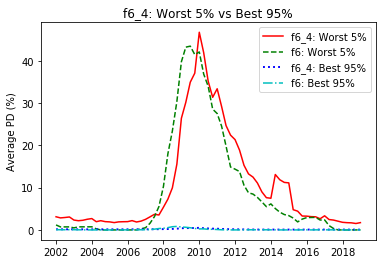

In [108]:
### f6_4 model:
xx4 = wg4['f6_4'] * 100  # convert to units of %
aa4 = wg4['f6'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx4[5],c='r',lw=1.5,label='f6_4: Worst 5%')
plt.plot(xg,aa4[5],c='g',ls='--',lw=1.5,label='f6: Worst 5%')
plt.plot(xg,xx4[95],c='b',ls=':',lw=1.9,label='f6_4: Best 95%')
plt.plot(xg,aa4[95],c='c',ls='-.',lw=1.5,label='f6: Best 95%')
plt.title('f6_4: Worst 5% vs Best 95%')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
#plt.ylim([0,.1])
plt.savefig('f6_4_wrst5_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

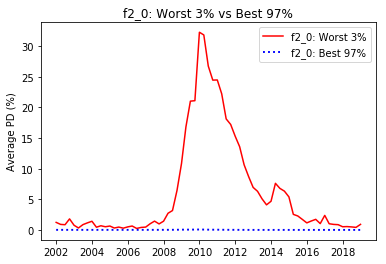

In [109]:
### f2_0 model:
xx0 = wg0['f2_0'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx0[3],c='r',lw=1.5,label='f2_0: Worst 3%')
plt.plot(xg,xx0[97],c='b',ls=':',lw=1.9,label='f2_0: Best 97%')
plt.title('f2_0: Worst 3% vs Best 97%')
plt.legend(loc=0)
plt.ylabel('Average PD (%)')
#plt.ylim([0,.1])
plt.savefig('f2_0_wrst3_modpd.png', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
xx0 = wg0['f2_0'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx0[97],c='b',ls=':',lw=1.8,label='f4_2: Best 97%')
plt.plot(xg,xx0[3],c='r',lw=1.5,label='f4_2: Worst 3%')
plt.title('f2_0: Worst 3% vs Best 97%')
plt.legend(loc=2)
plt.ylim([0,35])
plt.ylabel('Average PD (%)')
plt.xlabel('Year')

plt.subplot(1, 2, 2)
ax1 = plt.gca()
ax1.plot(xg,xx0[96],c='b',ls=':',lw=1.8,label=' Best 97%  (left scale) ')
ax1.set_ylabel('Best 97% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylim([0,.07])
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2, fontsize=11)

ax2 = ax1.twinx()
ax2.plot(xg,xx0[3],c='r',lw=1.5,label='Worst 3% (right scale)')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 3% PD (%)',color='r')
ax2.set_ylim([0,35])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.84), fontsize=11)

plt.title('f2_0: Worst 3% vs Best 97%')
ax1.set_xlabel('Year')

plt.savefig('f2_0_wrst3bst97_modpd_2charts.png', dpi=300, bbox_inches='tight')
plt.show()

In [111]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*1) )  ## double width, single height

plt.subplot(1, 2, 1)
xx4 = wg4['f6_4'] * 100  # convert to units of %
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx4[95],c='b',ls=':',lw=1.8,label='f6_4: Best 95%')
plt.plot(xg,xx4[5],c='r',lw=1.5,label='f6_4: Worst 5%')
plt.title('f6_4: Worst 5% vs Best 95%')
plt.legend(loc=2)
plt.ylim([0,60])
plt.ylabel('Average PD (%)')
plt.xlabel('Year')

plt.subplot(1, 2, 2)
ax1 = plt.gca()
ax1.plot(xg,xx4[95],c='b',ls=':',lw=1.8,label=' Best 95%  (left scale) ')
ax1.set_ylabel('Best 95% PD (%)', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylim([0,.6])
#plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.7))
ax1.legend(loc=2, fontsize=11)

ax2 = ax1.twinx()
ax2.plot(xg,xx4[5],c='r',lw=1.5,label='Worst 5% (right scale)')
# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Worst 5% PD (%)',color='r')
ax2.set_ylim([0,60])
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc='center left', bbox_to_anchor=(0.0, 0.84), fontsize=11)

plt.title('f6_4: Worst 5% vs Best 95%')
ax1.set_xlabel('Year')

plt.savefig('f6_4_wrst5bst95_modpd_2charts.png', dpi=300, bbox_inches='tight')
plt.show()

In [112]:
xx2['2009':'2011']

3          4          5         95        96        97
AsOf                                                                     
2009-03-31  34.639417  27.035065  22.164187  0.173422  0.199580  0.241112
2009-06-30  42.126311  33.024621  27.077115  0.186239  0.220479  0.274289
2009-09-30  43.762313  34.688060  28.575964  0.187568  0.229638  0.299633
2009-12-31  59.612049  47.305812  38.931287  0.209955  0.263006  0.365338
2010-03-31  57.304529  45.286464  37.056606  0.173910  0.217875  0.306685
2010-06-30  49.426533  38.678112  31.564757  0.146591  0.179790  0.240650
2010-09-30  45.320988  35.347968  28.885318  0.128465  0.158793  0.213220
2010-12-31  46.000407  35.832042  29.276122  0.121575  0.152119  0.205492
2011-03-31  41.816120  32.478218  26.387341  0.097452  0.120535  0.163758
2011-06-30  35.836990  27.765257  22.631468  0.084495  0.102896  0.139882
2011-09-30  33.370413  25.781710  20.936166  0.072048  0.086713  0.115705
2011-12-31  29.734330  22.908461  18.555380  0.067356  0.079305  0.104739

In [113]:
xx4['2009':'2011']

3          4          5         95        96        97
AsOf                                                                     
2009-03-31  44.698349  36.065614  30.182507  0.416221  0.481258  0.581268
2009-06-30  51.415813  41.674510  34.946920  0.446873  0.528458  0.647923
2009-09-30  53.320008  43.911921  37.085419  0.451521  0.550026  0.700534
2009-12-31  67.490726  55.580672  46.768538  0.497247  0.610481  0.806593
2010-03-31  61.492835  50.159585  41.923171  0.406910  0.499197  0.656239
2010-06-30  52.438076  42.285916  35.204683  0.345719  0.416346  0.530195
2010-09-30  46.502859  37.605013  31.376253  0.301596  0.365874  0.474784
2010-12-31  49.783657  40.050972  33.394164  0.288772  0.356283  0.464545
2011-03-31  44.250645  35.312615  29.216181  0.227394  0.278677  0.361785
2011-06-30  37.307110  29.805261  24.681743  0.196285  0.235134  0.309553
2011-09-30  34.258861  27.192966  22.419117  0.167507  0.199603  0.258192
2011-12-31  32.745525  25.976227  21.365937  0.156334  0.186055  0.243935

In [114]:
wg2.columns.levels[0]

Index(['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f4',
       'f4_2', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE',
       'rcTotLn'],
      dtype='object')

In [115]:
wg0.to_csv("f2_0_vars_worst345best959697.csv")
wg1.to_csv("f2_1_vars_worst345best959697.csv")
wg2.to_csv("f4_2_vars_worst345best959697.csv")
wg3.to_csv("f4_3_vars_worst345best959697.csv")
wg4.to_csv("f6_4_vars_worst345best959697.csv")
wg5.to_csv("f6_5_vars_worst345best959697.csv")

In [116]:
dff.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5', 'f2_0rr', 'f2_1rr', 'f4_2rr', 'f4_3rr',
       'f6_4rr', 'f6_5rr', 'f2_eT1rb', 'f4_eT1rb', 'f6_eT1rb', 'f2_qnTotLn',
       'f4_qnTotLn', 'f6_qnTotLn', 'f2_eBrok_Dep', 'f4_eBrok_Dep',
       'f6_eBrok_Dep', 'f2_lnTotAst', 'f4_lnTotAst', 'f6_lnTotAst', 'f2_rROA',
       'f4_rROA', 'f6_rROA', 'f2_rROE', 'f4_rROE', 'f6_rROE', 'f2_eLn_Dep',
       'f4_eLn_Dep', 'f6_eLn_Dep', 'f2_aFF_TA', 'f4_aFF_TA', 'f6_aFF_TA'],
      dtype='object')

In [117]:
len(dffw) # 489464

489464

In [118]:
dv4

idx  fx     v1        r1       v2        r2         v3        r3         v4  \
0   0  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192  eBrok_Dep   
1   1  f2  eT1rb  0.522124     rROE  0.574446    qnTotLn  0.598192   lnTotAst   
2   2  f4  eT1rb  0.397605  qnTotLn  0.484993       rROE  0.519184  eBrok_Dep   
3   3  f4  eT1rb  0.397605  qnTotLn  0.484993       rROA  0.519948  eBrok_Dep   
4   4  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROA   
5   5  f6  eT1rb  0.290698  qnTotLn  0.398956  eBrok_Dep  0.431118       rROE   

         r4       Int        c1        c2        c3        c4  
0  0.613497 -2.811573 -0.468536 -0.025506  0.085618  0.034020  
1  0.607907 -6.581040 -0.447051 -0.029119  0.085403  0.306151  
2  0.544654 -2.212869 -0.400314  0.112573 -0.029294  0.040637  
3  0.541713 -0.929336 -0.523156  0.118067 -0.311230  0.038045  
4  0.459380 -1.267605 -0.418450  0.147419  0.041354 -0.292336  
5  0.458963 -2.073528 -0.342457  0.140638  0.042748 -0.026583

In [119]:
wg2.head(2)

aFF_TA                                                    \
                  3         4         5         95        96        97   
AsOf                                                                     
2001-12-31  2.878028  2.612147  2.824287  6.035146  6.010509  5.967198   
2002-03-31  2.450562  2.300587  2.390398  5.574286  5.544939  5.506920   

            eALLL_Ln                                ...      rROE             \
                  3         4         5         95  ...        5          95   
AsOf                                                ...                        
2001-12-31  2.556635  2.297997  2.131351  1.433667  ... -1.585057  10.341568   
2002-03-31  2.389572  2.152216  2.028117  1.464297  ... -1.852633  10.484571   

                                  rcTotLn                                \
                  96         97        3         4         5         95   
AsOf                                                                      
2001-12-31  10.29716  10.227862  1.727906  1.497408  1.320337  0.320096   
2002-03-31  10.42957  10.373764  1.587409  1.336919  1.219133  0.311623   

                                
                  96        97  
AsOf                            
2001-12-31  0.323141  0.328124  
2002-03-31  0.316144  0.318883  

[2 rows x 96 columns]

In [120]:
wg2.columns

MultiIndex(levels=[['aFF_TA', 'eALLL_Ln', 'eBrok_Dep', 'eLn_Dep', 'eT1rb', 'eTotrb', 'f4', 'f4_2', 'lnTotAst', 'qnTotLn', 'rEff', 'rNIM', 'rPPNR', 'rROA', 'rROE', 'rcTotLn'], [3, 4, 5, 95, 96, 97]],
           codes=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15], [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])

In [121]:
vlst=['eT1rb','rROE','qnTotLn','eBrok_Dep']
vdsc = ['Tier 1 Risk-Based Capital','Rolling 4q ROE', 'Non-Accrual Loans','Brokered Deposits']
vdct = dict(zip(vlst,vdsc))
vdct

{'eT1rb': 'Tier 1 Risk-Based Capital',
 'rROE': 'Rolling 4q ROE',
 'qnTotLn': 'Non-Accrual Loans',
 'eBrok_Dep': 'Brokered Deposits'}

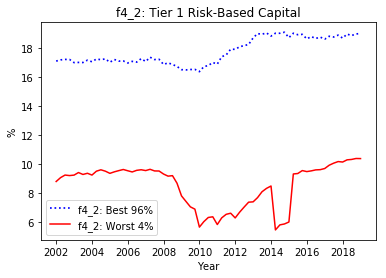

In [122]:
vc = 'eT1rb'
xx2 = wg2[vc] 
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: '+vdct[vc])
plt.legend(loc=0)
plt.ylabel('%')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('var_'+vc+'_wrst4.png', dpi=300, bbox_inches='tight')
plt.show()

In [123]:
vc = 'rROE'
xx2 = wg2[vc]
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: '+vdct[vc])
plt.legend(loc=0)
plt.ylabel('%')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('var_'+vc+'_wrst4.png', dpi=300, bbox_inches='tight')
plt.show()

In [124]:
vc = 'qnTotLn'
xx2 = wg2[vc]
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: '+vdct[vc])
plt.legend(loc=0)
plt.ylabel('%')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('var_'+vc+'_wrst4.png', dpi=300, bbox_inches='tight')
plt.show()

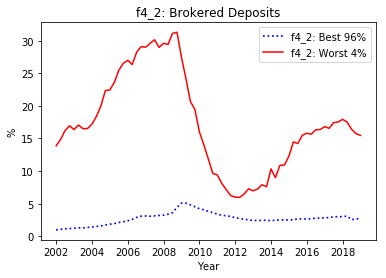

In [125]:
vc = 'eBrok_Dep'
xx2 = wg2[vc]
#xx.plot()  ## y-axis is %(pd)
plt.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
plt.title('f4_2: '+vdct[vc])
plt.legend(loc=0)
plt.ylabel('%')
plt.xlabel('Year')
#plt.ylim([0,.1])
plt.savefig('var_'+vc+'_wrst4.png', dpi=300, bbox_inches='tight')
plt.show()

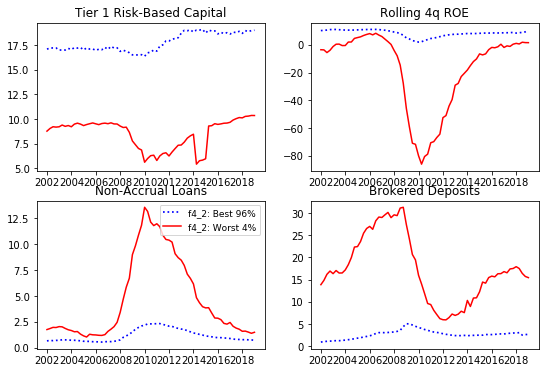

In [126]:
## Code to resize chart frame !!!!!!
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*1.5, plSize[1]*1.5) )  ## double width, single height

for i in np.arange(4):
  plt.subplot(2, 2, i+1)
  vc = vlst[i]
  xx2 = wg2[vc]
  plt.plot(xg,xx2[96],c='b',ls=':',lw=1.7,label='f4_2: Best 96%')
  plt.plot(xg,xx2[4],c='r',lw=1.5,label='f4_2: Worst 4%')
  plt.title(vdct[vc])
  if i ==2: plt.legend(loc=0,fontsize=9)
  #plt.ylabel('%')
  #plt.xlabel('Year')


plt.savefig('f4_2_wrst4bst96_4var.png', dpi=300, bbox_inches='tight')
plt.show()